<a href="https://colab.research.google.com/github/katsuki-nagakubo/Tweets_Word2vec/blob/master/model_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#データの取得と成形

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

#https://teratail.com/questions/128725

from ast import literal_eval
from pprint import pprint

f = open('/content/trump_test.txt', 'r')
text = f.read()
mylist = literal_eval(text)

df_text=[]
df_created_at=[]
df_id_str=[]

for i in range(len(mylist)):
    text = mylist[i]["text"]
    created_at = mylist[i]["created_at"]
    id_str = mylist[i]["id_str"]
    df_text.append(text)
    df_created_at.append(created_at)
    df_id_str.append(id_str)

tweet_list=[df_created_at,df_id_str,df_text]

columns1=["created_at"]
tweet_data = pd.DataFrame( data = df_created_at, columns = columns1)
tweet_data["id"]=df_id_str
tweet_data["text"] = df_text

tweet_data["time_created_at"] = pd.to_datetime(tweet_data['created_at'])
tweet_data["date_created_at"] = tweet_data["time_created_at"].dt.date
tweet_data["key"]=pd.to_datetime(tweet_data["date_created_at"])

sp_data = pd.read_csv('/content/sp500-10-year-daily-chart.csv')
sp_data["date_64"] = pd.to_datetime(sp_data["date"])
sp_data["key"] =sp_data["date_64"] 

tweet_data=pd.merge(tweet_data, sp_data)
tweet_data.columns
data = tweet_data[["key"," value","text"]]

#行の名前を変更する　20200505
data = data.rename(columns={"key": "date"," value":"price"})
data.head()

import datetime as dt
data2 = data[(data['date'] >= dt.datetime(2019,5,1)) & (data['date'] <= dt.datetime(2022,5,31))]
print( "2020/05/02 - 2020/05/31のツイート数は", len(data2))
data2.to_csv("s&p_tweets.csv", index=False, mode='a', header=True)

2020/05/02 - 2020/05/31のツイート数は 620


In [2]:
data = pd.read_csv("s&p_tweets.csv")
print( len(data),"tweets")

620 tweets


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


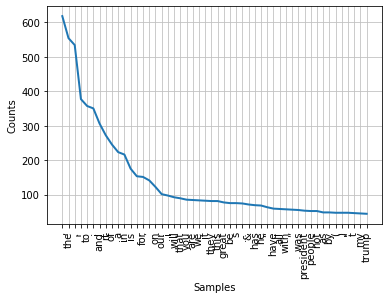

,Word,Frequency
0,",",618
1,the,554
2,.,534
3,!,377
4,to,357
5,:,350
6,and,306
7,rt,272
8,of,245
9,a,223


In [3]:
import nltk
nltk.download('stopwords')

tweet_tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

words = []
for tweet in data["text"]:
    words += tweet_tokenizer.tokenize(tweet)

fdist = nltk.FreqDist(words)
fdist.plot(50)

df_fdist = pd.DataFrame(fdist.most_common(10), columns=['Word', 'Frequency'])
df_fdist

In [0]:
import re
import string

stemmer = nltk.stem.PorterStemmer()
punctuations = string.punctuation
all_tweets_clean = []

#Tweet毎にリスト形式で保存するための加工
result=[]

for tweet in data["text"]:
    # RTから始まる部分を取り除く。
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # リンクを取り除く。
    tweet = re.sub(r'(http|https):\/\/.*[\r\n]*', '', tweet)
    # ハッシュタグを取り除く。
    tweet = re.sub(r'#', '', tweet)
    # 句読点の削除
    tweet = tweet.translate(str.maketrans('', '', string.punctuation)) 
    # 単語に分解する。
    tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    result.append(tweet_tokens)
    
stopwords = nltk.corpus.stopwords.words('english')
stop_words = ["→", "←", "?", "」", "「","(",")","!",".",",","&","…","%",":",";","“"]
stopwords += stop_words

#print(stopwords)

result_2=[]
result_3=[]
for i in range(len(result)):
    for word in result[i]:
        if word not in stopwords:
            result_2.append(word)
    result_3.append(result_2)
    result_2=[]

In [5]:
from gensim.models import word2vec
skipgram_model = word2vec.Word2Vec.load("/content/skipgram_w2v.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
num_features = 300


def avg_document_vector(data, num_features):
    document_vec = np.zeros((len(data), num_features))
    for i, doc_word_list in enumerate(data):
        feature_vec = np.zeros((num_features,), dtype="float32")
        for word in doc_word_list:
            try:
                feature_vec = np.add(
                    feature_vec, skipgram_model.wv.__getitem__(word))
            except:
                pass

        feature_vec = np.divide(feature_vec, len(doc_word_list))
        document_vec[i] = feature_vec
    return document_vec

In [7]:
sentences = result_3
sentences[0]

X = avg_document_vector(data=sentences, num_features=300)
X.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


(620, 300)

In [0]:
data2 = pd.DataFrame(X)
df_tweets_word2vec =  pd.concat([data, data2], axis=1)

df_tweets_word2vec.to_csv("price_tweets_vector.csv", index=False)

#ツイートのベクトルを1日毎に平均にする（1日10ツイートだった場合ベクトルと足し合わせ10で割る）
# groupby #https://qiita.com/propella/items/a9a32b878c77222630ae
df = df_tweets_word2vec.groupby(["date"]).mean()


# targetのcolである変化率（"price"の差分対数行列）をdateをKeyに内部結合する
df_sp = pd.read_csv("/content/sp500-10-year-daily-chart.csv")

# 時系列データの差分を求める

# " value"の行を対数化
# https://www.sejuku.net/blog/70027
df_sp["log"] = np.log(df_sp[" value"])

# "log"の1日前との差を取って、差分対数の列を作成
# https://note.nkmk.me/python-pandas-diff-pct-change/
df_sp["dif_log"] = df_sp["log"].diff()

#内部結合
df2=pd.merge(df_sp, df, how="inner" ,on="date")
df2 = df2.drop(" value", axis=1)

# groupbyを使って1日のツイート数も特徴量に加える
# https://deepage.net/features/pandas-count.html
df3 = df_tweets_word2vec[["date","text"]]
df3 = df3.groupby(["date"]).count()

#内部結合
df4 = pd.merge( df3, df2, how="inner" ,on="date")

date_for_result = df4["date"]

#日付データの形を変える
df4["date"] = pd.to_datetime(df4['date']).astype('int64')

In [0]:
#特徴量とターゲットを決める
from sklearn.model_selection import train_test_split

target_col = 'dif_log'
exclude_cols = ['log', 'price', 'dif_log', "date","text"]
feature_cols = []
for col in df4.columns:
    if col not in exclude_cols:
        feature_cols.append(col)
        
X = np.array(df4[feature_cols])
y = np.array(df4[target_col])

In [10]:
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LinearRegression  # 線形回帰モデルのライブラリ
from sklearn.metrics import mean_squared_error  # MSEのライブラリ
from sklearn.ensemble import RandomForestRegressor

from sklearn.externals import joblib
import pickle

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Linear Regression　: RMSE 0.408
Decision Tree　: RMSE 0.103
Random Forest　: RMSE 0.054
Random Forest Best　: RMSE 0.056


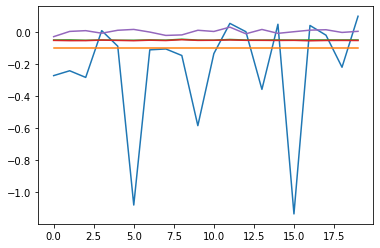

In [30]:
files = [("Linear Regression",'/content/lm_model.sav'),("Decision Tree",'/content/dt_model.sav'),("Random Forest",'/content/rf_model.sav'),("Random Forest Best",'/content/rf_best_model.sav')]
df_result = pd.DataFrame(df4["dif_log"])

for i,(name,filename) in enumerate(files):
  loaded_model = pickle.load(open(filename, 'rb'))
  y_pred = loaded_model.predict(X)
  mse = mean_squared_error(y, y_pred)
  df_result[name] = y_pred
  print(name+"　: RMSE", round(np.sqrt(mse), 3))
  plt.plot(df_result[name])
plt.plot(df_result["dif_log"])

plt.show()

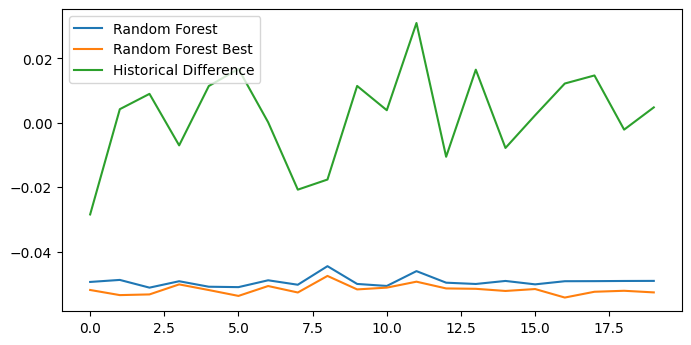

In [32]:
fig = plt.figure(figsize=(8,4),dpi=100)
rf = plt.plot(df_result["Random Forest"])
rf_b =plt.plot(df_result["Random Forest Best"])
sp = plt.plot(df_result["dif_log"])
plt.legend((rf[0], rf_b[0],sp[0]), ("Random Forest", "Random Forest Best", "Historical Difference"), loc=2)